In [2]:
#import modules
import SimpleITK as sitk

from platipy.imaging.visualisation.tools import ImageVisualiser
from platipy.imaging.utils.tools import get_com
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

from platipy.imaging.visualisation.tools import ImageVisualiser

from platipy.imaging.registration.registration import (
    initial_registration,
    fast_symmetric_forces_demons_registration,
    transform_propagation,
    apply_field
)

In [3]:
#breast=sitk.ReadImage("/home/alicja/Downloads/Segmentation.nii.gz") #right breast
breast=sitk.ReadImage("contralateral_segmentation.nii.gz")

pat_no="14"
timept="4"

filenameB50T_1="WES_014_4_20181126_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B50T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_5.nii.gz"
filenameB800T_1="WES_014_4_20181126_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B800T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_5.nii.gz"
filenameT2w_1="WES_014_4_20181126_MR_T2_TSE_TRA_SPAIR_TSE2D1_11_T2_TSE_TRA_SPAIR_3.nii.gz"
filenameMPE_1="max_img_WES_0" +pat_no+"_"+timept+".nii.gz"

WES_1_B50T=sitk.ReadImage("/home/alicja/Documents/WES_0" + pat_no + "/IMAGES/" +filenameB50T_1)
WES_1_B800T=sitk.ReadImage("/home/alicja/Documents/WES_0" + pat_no + "/IMAGES/" +filenameB800T_1)
WES_1_T2w=sitk.ReadImage("/home/alicja/Documents/WES_0" + pat_no + "/IMAGES/" +filenameT2w_1)
WES_1_MPE=sitk.ReadImage(filenameMPE_1)

WES_010_4_B50T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_4_20180829_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B50T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_MIX_5.nii.gz")

In [4]:
image_to_0_rigid, tfm_to_0_rigid = initial_registration(
    WES_1_B50T,
    WES_010_4_B50T,
    options={
        'shrink_factors': [8,4],
        'smooth_sigmas': [0,0],
        'sampling_rate': 0.5,
        'final_interp': 2,
        'metric': 'mean_squares',
        'optimiser': 'gradient_descent_line_search',
        'number_of_iterations': 25},
    reg_method='Rigid')

image_to_0_dir, tfm_to_0_dir = fast_symmetric_forces_demons_registration(
    WES_1_B50T,
    image_to_0_rigid,
    resolution_staging=[4,2],
    iteration_staging=[10,10]
)

breast_to_0_rigid = transform_propagation(
    WES_1_B50T,
    breast,
    tfm_to_0_rigid,
    structure=True
)

breast_to_0_dir = apply_field(
    breast_to_0_rigid,
    tfm_to_0_dir,
    structure=True
)

In [5]:
vis = ImageVisualiser(WES_1_B50T, axis='z', cut=get_com(breast_to_0_dir), window=[0, 500])
vis.add_contour(breast_to_0_dir, name='BREAST', color='g')
fig = vis.show()

invalid value encountered in double_scalars


ValueError: cannot convert float NaN to integer

In [ ]:
breast_contour_dilate=sitk.BinaryDilate(breast_to_0_dir, (5,5,5))

In [ ]:
vis = ImageVisualiser(WES_1_B50T, axis='z', cut=get_com(breast_to_0_dir), window=[0, 500])
vis.add_contour(breast_contour_dilate, name='BREAST', color='g')
fig = vis.show()

In [ ]:
masked_breast = sitk.Mask(WES_1_B50T, breast_contour_dilate)

In [ ]:
values = sitk.GetArrayViewFromImage(masked_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,1500,50), histtype='stepfilled', lw=2)
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [ ]:
def estimate_tumour_vol(img_mri, lowerthreshold=300, upperthreshold=5000, hole_size=1):
    label_threshold = sitk.BinaryThreshold(img_mri, lowerThreshold=lowerthreshold, upperThreshold=upperthreshold)
    label_threshold_cc = sitk.RelabelComponent(sitk.ConnectedComponent(label_threshold))
    label_threshold_cc_x = (label_threshold_cc==1)
    label_threshold_cc_x_f = sitk.BinaryMorphologicalClosing(label_threshold_cc_x, (hole_size,hole_size,hole_size))
    return(label_threshold_cc_x_f)

In [ ]:
image_mri=WES_1_B50T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,:arr_mri.shape[2]//2] = 0 #if laterality is L
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=480, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_0" + pat_no + "_" +timept +"_B50T_hist.nii.gz")

In [ ]:
masked_breast = sitk.Mask(WES_1_B800T, breast_contour_dilate)

values = sitk.GetArrayViewFromImage(masked_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,750,50), histtype='stepfilled', lw=2)
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [ ]:
image_mri=WES_1_B800T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,:arr_mri.shape[2]//2] = 0 #if lat is L
arr_mri[:,:,148:]=0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=260, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_0" + pat_no + "_" +timept +"_B800T_hist.nii.gz")

In [ ]:
WES_1_T2w=sitk.Resample(WES_1_T2w,WES_1_B50T)
masked_breast = sitk.Mask(WES_1_T2w, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,250,50), histtype='stepfilled', lw=2)
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [ ]:
image_mri=WES_1_T2w
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,:arr_mri.shape[2]//2] = 0 #if lat is L
arr_mri[:15,:,:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=80, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_0" + pat_no + "_" +timept +"_T2w_hist.nii.gz")

In [ ]:
WES_1_MPE=sitk.Resample(WES_1_MPE,WES_1_B50T)
masked_breast = sitk.Mask(WES_1_MPE, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,300,50), histtype='stepfilled', lw=2)
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [6]:
image_mri=WES_1_MPE
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,:arr_mri.shape[2]//2] = 0 #if lat is L
arr_mri[:,:,:115] = 0
arr_mri[:,:,148:]=0
arr_mri[:15,:,:]=0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=110, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_0" + pat_no + "_" +timept +"_MPE_hist.nii.gz")

NameError: name 'estimate_tumour_vol' is not defined

<IPython.core.display.Javascript object>


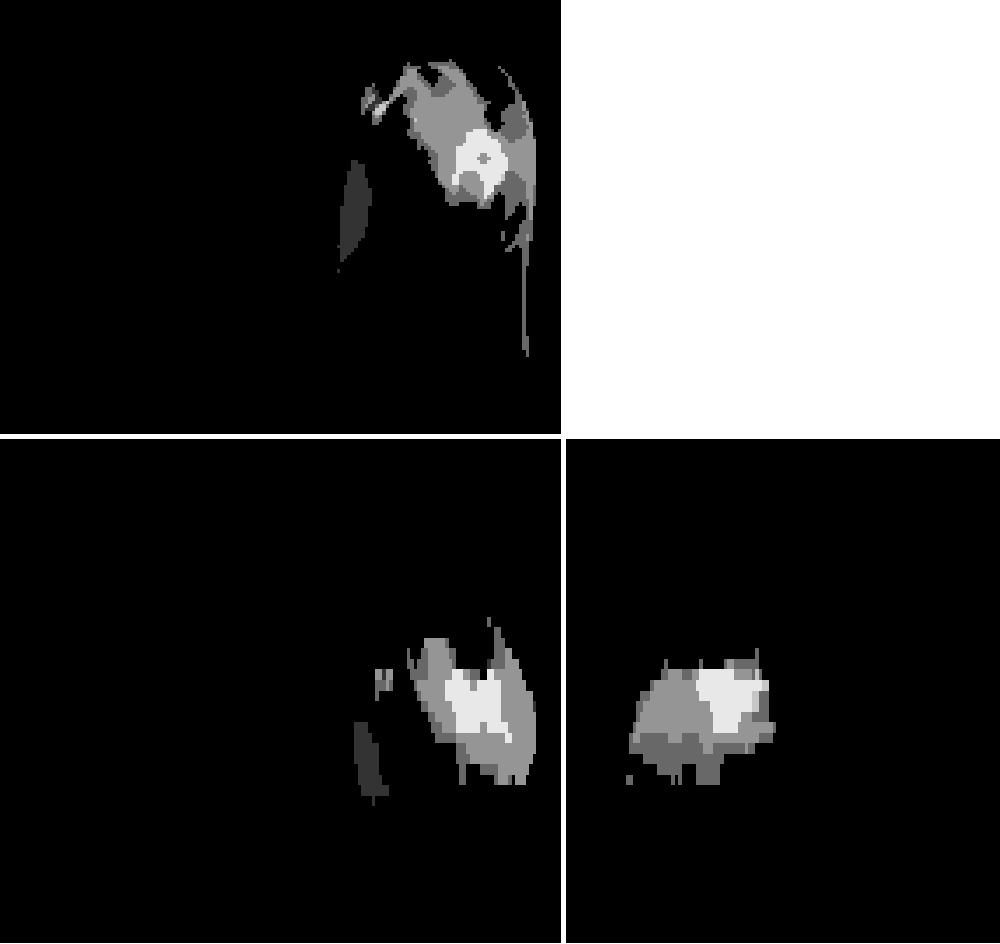

In [7]:
#add segs
seg_B50T=sitk.ReadImage("test_label_threshold_0" + pat_no + "_" +timept +"_B50T_hist.nii.gz")
seg_B800T=sitk.ReadImage("test_label_threshold_0" + pat_no + "_" +timept +"_B800T_hist.nii.gz")
seg_T2=sitk.ReadImage("test_label_threshold_0" + pat_no + "_" +timept +"_T2w_hist.nii.gz")
seg_MPE=sitk.ReadImage("test_label_threshold_0" + pat_no + "_" +timept +"_MPE_hist.nii.gz")

seg_B50T=sitk.Resample(seg_B50T,seg_T2)
seg_B800T=sitk.Resample(seg_B800T,seg_T2)
seg_MPE=sitk.Resample(seg_MPE,seg_T2)

new_seg_T2=sitk.LabelMapToBinary(sitk.Cast(seg_T2, sitk.sitkLabelUInt8))
new_seg_B50T=sitk.LabelMapToBinary(sitk.Cast(seg_B50T, sitk.sitkLabelUInt8))
new_seg_B800T=sitk.LabelMapToBinary(sitk.Cast(seg_B800T, sitk.sitkLabelUInt8))
new_seg_MPE=sitk.LabelMapToBinary(sitk.Cast(seg_MPE, sitk.sitkLabelUInt8))

new_TRACE_seg=(new_seg_B50T+new_seg_B800T)/2
new_seg_1=(sitk.Cast(new_seg_T2,sitk.sitkFloat64)+sitk.Cast(new_TRACE_seg,sitk.sitkFloat64)+sitk.Cast(new_seg_MPE,sitk.sitkFloat64))
vis=ImageVisualiser(new_seg_1, cut=get_com(new_seg_1), window=[0,3])
fig=vis.show()

<IPython.core.display.Javascript object>


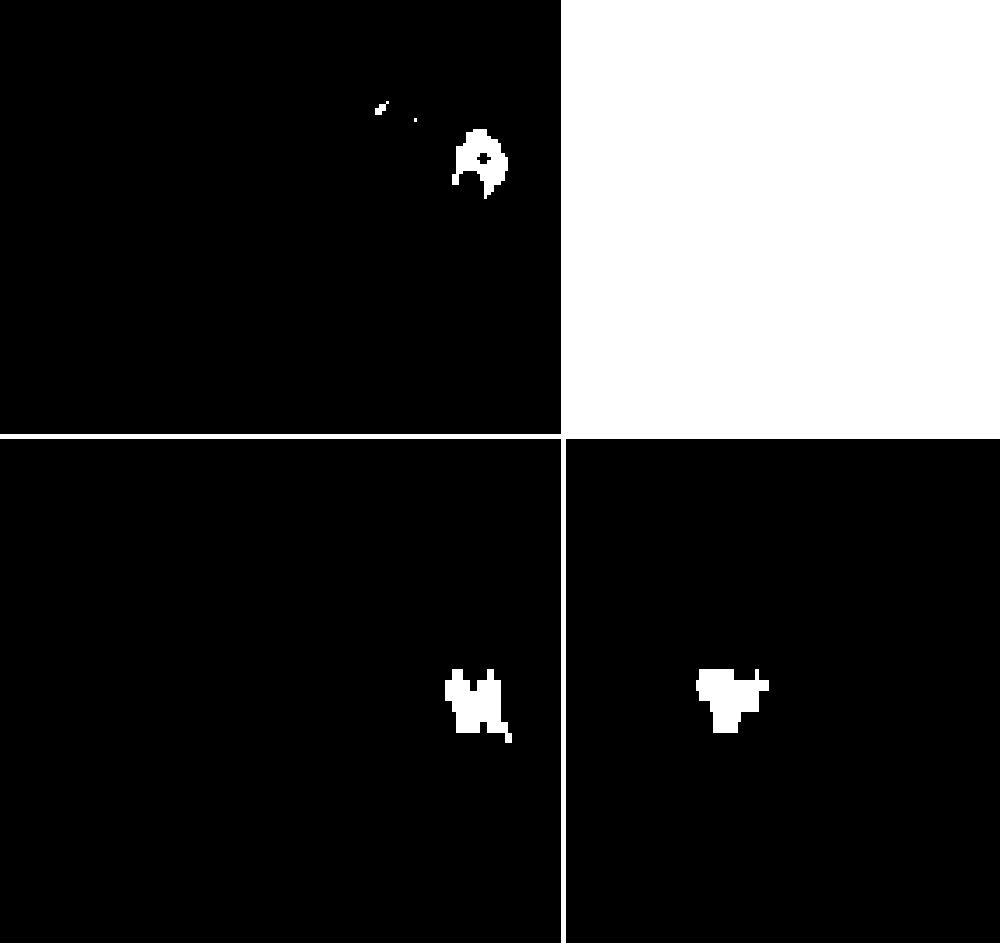

In [8]:
new_seg_1_1=sitk.BinaryThreshold(new_seg_1, lowerThreshold=2)

vis=ImageVisualiser(new_seg_1_1, cut=get_com(new_seg_1), window=[0,1])
fig=vis.show()

In [9]:
sitk.WriteImage(new_seg_1_1,"new_seg_0"+pat_no+"_"+timept+"_mri.nii.gz")

In [6]:
#Checking for volume decrease

tp1=
tp2=
tp3=

#volumes
img1=sitk.ReadImage("new_seg_0"+pat_no+"_"+tp1+"_mri.nii.gz")
img2=sitk.ReadImage("new_seg_0"+pat_no+"_"+tp2+"_mri.nii.gz")
img3=sitk.ReadImage("new_seg_0"+pat_no+"_"+tp3+"_mri.nii.gz")

arr1=sitk.GetArrayFromImage(img1)
arr2=sitk.GetArrayFromImage(img2)
arr3=sitk.GetArrayFromImage(img3)

vol1=np.sum(arr1==1)
vol2=np.sum(arr2==1)
vol3=np.sum(arr3==1)

print(vol1, vol2, vol3)

SyntaxError: invalid syntax (<ipython-input-6-807f0320aaca>, line 1)